### Motivation

This notebook is the product of working on exercises one and two of the David Silver Reinforcement learning course.  http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/Easy21-Johannes.pdf The purpose was to build intuition on how simple reinforcement learning works.  

### Environment

In [1]:
import numpy as np


def card():
    return np.random.randint(1, 11)


def color():
    n = np.random.rand()
    if n <= .333333:
        return 'r'
    else:
        return 'b'


def draw():
    if color() == 'r':
        c = card() * -1
    else:
        c = card()
    return c


def step(state):
    dealer = state[0]
    player = state[1]
    action = state[2]
    score = state[3]
    if action == 'other':
        dealer = card()
        player = card()
        action = 'start'
    if action == 'hit':
        player = player + draw()
        if player > 21:
            score = -1
            action = 'done'
    if action == 'stick':
        while dealer < 17:
            dealer = dealer + draw()
        if dealer > 21:
            score = 1
        if dealer == player:
            score = 0
        if dealer > player:
            score = -1
        if player > dealer:
            score = 1
        action = 'done'
    return [dealer, player, action, score]


### Interacting with environment

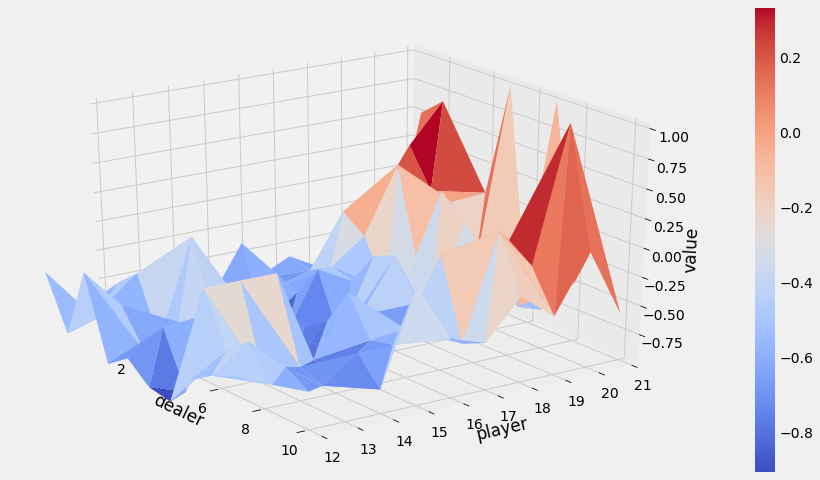

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D



Axes3D
def incremental_mean(x, u, k):
    """
    calculates incremental mean
    :param x: current reward
    :param u: mean of existing rewards
    :param k: number of times state action pair has been seen
    :return: new state action value
    """
    return u + ((1 / k) * (x - u))


def egreedy_exploration(k, k_fixed=100):
    return k_fixed / (k_fixed + k)


def random_action():
    if np.random.random() > .5:
        return 'hit'
    else:
        return 'stick'


states = []
action_rewards = []

# TODO why are my numbers shifted lower.  Expect 21 to have argmax of around 1
for x in range(500):
        state = [0, 0, 'other', np.nan]
        state = step(state)
        current_states_index = []
        current_actions = []
        while state[2] != 'done':

            while state[1] < 10:
                state[2] = 'hit'
                state = step(state)
            if state[:2] in states:
                # previous_state = state[2:]
                index = states.index(state[:2])
                current_states_index.append(index)
                actions = action_rewards[index]
                previous_rewards = action_rewards[index]
                if egreedy_exploration(previous_rewards[2]) < np.random.random():
                    previous_action = random_action()
                    state[2] = previous_action
                    current_actions.append(previous_action)
                elif previous_rewards[0] == previous_rewards[1]:
                    previous_action = random_action()
                    state[2] = previous_action
                    current_actions.append(previous_action)
                else:
                    if previous_rewards[0] > previous_rewards[1]:
                        previous_action = 'stick'
                        state[2] = previous_action
                        current_actions.append(previous_action)
                    else:
                        previous_action = 'hit'
                        state[2] = previous_action
                        current_actions.append(previous_action)
                state = step(state)
                if state[2] == 'done':
                    for cur_state in range(len(current_states_index)):
                        if previous_action == 'stick':
                            action_rewards[current_states_index[cur_state]][0] = incremental_mean(state[3],
                                                                                                  action_rewards[
                                                                                                      current_states_index[
                                                                                                          cur_state]][
                                                                                                      0],
                                                                                                  action_rewards[
                                                                                                      current_states_index[
                                                                                                          cur_state]][
                                                                                                      2])
                        elif previous_action == 'hit':
                            action_rewards[current_states_index[cur_state]][1] = incremental_mean(state[3],
                                                                                                  action_rewards[
                                                                                                      current_states_index[
                                                                                                          cur_state]][
                                                                                                      1],
                                                                                                  action_rewards[
                                                                                                      current_states_index[
                                                                                                          cur_state]][
                                                                                                      2])
                        action_rewards[current_states_index[cur_state]][2] = action_rewards[index][2] + 1
            else:
                states.append(state[:2])
                action_rewards.append([0, 0, 1])

# %%


action_df = pd.DataFrame(action_rewards, columns=['stick', 'hit', 'visits'])
state_df = pd.DataFrame(states, columns=['dealer', 'player'])
df = pd.concat([action_df, state_df], axis=1)
df['max'] = df[['hit', 'stick']].max(axis=1)
df.to_csv('monte_carlo.csv')

# %%


plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(14, 8))

ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('dealer')
ax.set_ylabel('player')
ax.set_zlabel('value')
ax.set_ylim(12, 21)
ax.view_init(25, -35)
surf = ax.plot_trisurf(df['dealer'], df['player'], df['max'], cmap=cm.coolwarm)
fig.colorbar(surf)
plt.show()


### Results

We can see from the visualization that we have found a smooth decision boundary. The values for states that are close to 21 should be closer to 1 than they currently are. They seem to be shifted downward for some reason. The agend does seem to be choosing the correct action even though this is happening.  